### Store Sales Forescasting

For the Kaggle competition [Store Sales](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview)

Forecast store sales based on data from Corporación Favorita, a large Ecuadorian-based grocery retailer.

<b>train.csv</b>

- The training data, comprising time series of features <b>store_nbr</b>, <b>family</b>, and <b>onpromotion</b> as well as the target <b>sales</b>.
- <b>store_nbr</b> identifies the store at which the products are sold.
- <b>family</b> identifies the type of product sold.
- <b>sales</b> gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
- <b>onpromotion</b> gives the total number of items in a product family that were being promoted at a store at a given date.

<b>test.csv</b>

- The test data, having the same features as the training data. You will predict the target <b>sales</b> for the dates in this file.
- The dates in the test data are for the 15 days after the last date in the training data.

<b>sample_submission.csv</b>

- A sample submission file in the correct format.

<b>stores.csv</b>

- Store metadata, including <b>city</b>, <b>state</b>, <b>type</b>, and <b>cluster</b>.
- <b>cluster</b> is a grouping of similar stores.

<b>oil.csv</b>

- Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

<b>holidays_events.csv</b>

- Holidays and Events, with metadata
NOTE: Pay special attention to the <b>transferred</b> column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
- Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

<b>Additional Notes</b>

- Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.
- A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

Scoring based on <b>RMSLE</b>

In [1]:
#The Following cell of code is used everytime FASTAI library is used.
#They tell the notebook to reload any changes made to any libraries used.
#They also ensure that any graphs are plotted are shown in this notebook
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.tabular.all import *
from fastbook import *

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_log_error

import seaborn as sns

from dtreeviz.trees import *
import dtreeviz

In [3]:
#| export
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
creds = ''


In [4]:
#| export
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)


In [5]:
#| export
path = Path('store-sales-time-series-forecasting')

In [6]:
#| export
if not iskaggle and not path.exists():
    import zipfile, kaggle
    kaggle.api.competition_download_cli(str(path))    
    zipfile.ZipFile(f'{path}.zip').extractall(path)


In [7]:
#| export
if iskaggle:
    path = Path('../input/store-sales-time-series-forecasting')
    ! pip install -q dataset

In [8]:
[x for x in path.ls()]

[Path('store-sales-time-series-forecasting/sample_submission.csv'),
 Path('store-sales-time-series-forecasting/holidays_events.csv'),
 Path('store-sales-time-series-forecasting/oil.csv'),
 Path('store-sales-time-series-forecasting/test.csv'),
 Path('store-sales-time-series-forecasting/train.csv'),
 Path('store-sales-time-series-forecasting/transactions.csv'),
 Path('store-sales-time-series-forecasting/stores.csv')]

In [9]:
train_df = pd.read_csv(path/'train.csv', low_memory=False)
test_df = pd.read_csv(path/'test.csv', low_memory=False)
sample_df = pd.read_csv(path/'sample_submission.csv', low_memory=False)
stores_df = pd.read_csv(path/'stores.csv', low_memory=False)
oil_df = pd.read_csv(path/'oil.csv', low_memory=False)
hol_events_df = pd.read_csv(path/'holidays_events.csv', low_memory=False)
transactions_df = pd.read_csv(path/'transactions.csv', low_memory=False)

In [10]:
train_df['date'] = pd.to_datetime(train_df['date'])
train_df.sample(n=5)

,id,date,store_nbr,family,sales,onpromotion
2483653,2483653,2016-10-28,46,CLEANING,2576.000,61
2761877,2761877,2017-04-03,52,DAIRY,0.000,0
1217988,1217988,2014-11-16,33,MEATS,357.354,2
1231938,1231938,2014-11-24,25,HOME AND KITCHEN I,5.000,0
528175,528175,2013-10-24,29,EGGS,0.000,0


In [11]:
# train_df = add_datepart(train_df, 'date')

In [12]:
combined_df = train_df

In [13]:
train_df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [48]:
train_df.shape

(3000888, 6)

In [14]:
train_df.sort_values(by='date')

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1194,1194,2013-01-01,42,CELEBRATION,0.000,0
1193,1193,2013-01-01,42,BREAD/BAKERY,0.000,0
1192,1192,2013-01-01,42,BOOKS,0.000,0
1191,1191,2013-01-01,42,BEVERAGES,0.000,0
...,...,...,...,...,...,...
2999693,2999693,2017-08-15,25,PET SUPPLIES,3.000,0
2999692,2999692,2017-08-15,25,PERSONAL CARE,93.000,8
2999691,2999691,2017-08-15,25,MEATS,180.107,0
2999702,2999702,2017-08-15,26,BEAUTY,0.000,0


In [15]:
test_df['date'] = pd.to_datetime(test_df['date'])
# test_df = add_datepart(test_df, 'date')
test_df.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [16]:
# combined_df = pd.concat([train_df, test_df], ignore_index=True)
# combined_df.sort_values(by='id')

In [17]:
# hol_events_df['date'] = pd.to_datetime(hol_events_df['date'])
# hol_events_df.head()

In [18]:
# combined_df = pd.merge(combined_df, hol_events_df, on='date').set_index('date').drop_duplicates()
# combined_df.head()

In [19]:
stores_df.sample(n=5)

,store_nbr,city,state,type,cluster
39,40,Machala,El Oro,C,3
49,50,Ambato,Tungurahua,A,14
18,19,Guaranda,Bolivar,C,15
41,42,Cuenca,Azuay,D,2
38,39,Cuenca,Azuay,B,6


In [20]:
oil_df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [21]:
transactions_df.tail()

,date,store_nbr,transactions
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932
83487,2017-08-15,54,802


In [22]:
test_df.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [23]:
def get_null_counts(df):
    null_count_df = pd.DataFrame((df.isnull().sum()).sort_values(ascending=False).reset_index())
    null_count_df.columns = ['column_name','null_counts']
    null_count_df = null_count_df.query("column_name!='Sales'")
    return null_count_df

In [24]:
null_= get_null_counts(train_df)
null_.style.background_gradient(cmap='YlOrRd')

,column_name,null_counts
0,id,0
1,date,0
2,store_nbr,0
3,family,0
4,sales,0
5,onpromotion,0


#### Quick baseline model

In [25]:
dep_var = 'sales'

In [26]:
# combined_df[dep_var] = np.log(combined_df[dep_var])
# combined_df[dep_var] = np.log(combined_df[dep_var]).replace(0, np.finfo(float).eps))

In [27]:
train_df[dep_var] = np.log(train_df[dep_var] + 1e-5)

In [28]:
procs = [Categorify, FillMissing, Normalize]

In [29]:
train_df['date'].tail()

3000883   2017-08-15
3000884   2017-08-15
3000885   2017-08-15
3000886   2017-08-15
3000887   2017-08-15
Name: date, dtype: datetime64[ns]

In [30]:
train_df['date'] < pd.to_datetime('2017-01-01')

0           True
1           True
2           True
3           True
4           True
           ...  
3000883    False
3000884    False
3000885    False
3000886    False
3000887    False
Name: date, Length: 3000888, dtype: bool

In the interest of getting the baseline model up and running as quickly as possible, all training data will be before the earthquake. In the future the earthquake data will be incorporated, or dropped if it causes significant issues

In [31]:
# cond = (df.date < 2016) | ((df.saleMonth<10) & (df.saleYear==2011))
cond = train_df.date < pd.to_datetime("2016-04-01")

Training and validation set indexes where `cond` is true or false

In [32]:
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

In [33]:
train_idx

array([      0,       1,       2, ..., 2108103, 2108104, 2108105])

Assign the training and validation indexs to splits as a tuple of lists

In [34]:
splits = (list(train_idx), list(valid_idx))

Split continuous and categorical variables, with a max cardinality of 1

In [35]:
cont, cat = cont_cat_split(train_df, 1, dep_var=dep_var)

Create tabular pandas object

In [36]:
to = TabularPandas(train_df, procs, cat, cont, y_names=dep_var, splits=splits)

In [37]:
to.train.y

0         -11.512925
1         -11.512925
2         -11.512925
3         -11.512925
4         -11.512925
             ...    
2108101     5.935407
2108102     4.599353
2108103     7.185743
2108104     1.098616
2108105     3.051877
Name: sales, Length: 2108106, dtype: float32

In [38]:
xs, y = to.train.xs, to.train.y

In [39]:
valid_xs, valid_y = to.valid.xs, to.valid.y

In [40]:
to.items

,id,date,store_nbr,family,sales,onpromotion
0,-1.732050,1,-1.700267,1,-11.512925,-0.130362
1,-1.732048,1,-1.700267,2,-11.512925,-0.130362
2,-1.732047,1,-1.700267,3,-11.512925,-0.130362
3,-1.732045,1,-1.700267,4,-11.512925,-0.130362
4,-1.732043,1,-1.700267,5,-11.512925,-0.130362
...,...,...,...,...,...,...
3000883,3.199089,0,-1.186979,29,6.082522,-0.130362
3000884,3.199091,0,-1.186979,30,5.040537,0.004929
3000885,3.199092,0,-1.186979,31,7.791411,19.892806
3000886,3.199094,0,-1.186979,32,4.795791,0.951971


#### Decision Tree Regressor

Create `DecisionTreeRegressor` object, ensuring at least 25 sales records per leaf node

In [41]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(xs, y)

DecisionTreeRegressor(min_samples_leaf=25)

In [42]:
# draw_tree(m, xs, size=12, leaves_parallel=True, precision=2 )

Function to compute *mean square error*

In [43]:
def r_mse(pred, y):
    return round(math.sqrt(((pred-y)**2).mean()), 6)

Function to run `r_mse` prediction on a model

In [44]:
def m_rmse(m, xs, y):
    return r_mse(m.predict(xs), y)

Quick score check on the training set

In [45]:
m_rmse(m, xs, y)

2.199012

Quick check of model score on the validation sets

In [46]:
m_rmse(m, valid_xs, valid_y)

3.849907

Get the number of leaves that were created at `min_samples_leaf=25`

In [47]:
m.get_n_leaves()

46939

#### Random Forest Regressor

Create a function `rf` for faster repeated variations

In [49]:
def rf(xs, y, n_estimators=40, max_samples=200_000, max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators, 
                                 max_samples=max_samples, max_features=max_features,
                                 min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [50]:
m = rf(xs, y)

In [51]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(2.637344, 4.169406)

In [52]:
m.estimators_

[DecisionTreeRegressor(max_features=0.5, min_samples_leaf=5,
                       random_state=1659498278),
 DecisionTreeRegressor(max_features=0.5, min_samples_leaf=5,
                       random_state=215876332),
 DecisionTreeRegressor(max_features=0.5, min_samples_leaf=5,
                       random_state=261179676),
 DecisionTreeRegressor(max_features=0.5, min_samples_leaf=5,
                       random_state=495096495),
 DecisionTreeRegressor(max_features=0.5, min_samples_leaf=5,
                       random_state=826578914),
 DecisionTreeRegressor(max_features=0.5, min_samples_leaf=5,
                       random_state=665947520),
 DecisionTreeRegressor(max_features=0.5, min_samples_leaf=5,
                       random_state=1777393527),
 DecisionTreeRegressor(max_features=0.5, min_samples_leaf=5,
                       random_state=225462780),
 DecisionTreeRegressor(max_features=0.5, min_samples_leaf=5,
                       random_state=836027699),
 DecisionTreeRegr

Check the impact of n_estimators

In [59]:
m.predict(valid_xs.values)[0]

/home/petewin/mambaforge/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names


-0.8446616855120735

In [56]:
preds = np.stack([t.predict(valid_xs.values) for t in m.estimators_])

In [62]:
preds

array([[ 1.44068379e+00, -1.15129251e+01, -8.75541202e+00, ...,  1.37339020e+00, -1.15129251e+01,  3.35359293e+00],
       [-1.88669122e+00, -1.15129251e+01, -9.21914403e-01, ...,  7.74713961e+00,  4.49681465e+00, -1.15129251e+01],
       [-6.28279467e-03, -1.15129251e+01,  3.84459185e+00, ...,  7.24458170e+00,  3.99534098e+00,  2.57146299e+00],
       ...,
       [ 1.52718495e+00, -7.51596057e-01, -7.51596057e-01, ...,  6.94781521e+00,  3.13169422e+00,  2.28571391e-01],
       [-3.10162167e-01, -3.10162167e-01, -3.10162167e-01, ...,  8.32971561e+00,  4.38210013e+00, -8.59740033e+00],
       [ 1.84610086e+00, -1.15129251e+01,  9.45014594e-01, ...,  7.75005317e+00,  4.88352414e+00, -2.34139930e+00]])

In [60]:
r_mse(preds.mean(), valid_y)

6.400219

`preds.mean(0)` will give the same results as the random forest

In [57]:
r_mse(preds.mean(0), valid_y)

4.169406

Plot incremental increases in number of trees and resulting change

In [63]:
preds[:]

array([[ 1.44068379e+00, -1.15129251e+01, -8.75541202e+00, ...,  1.37339020e+00, -1.15129251e+01,  3.35359293e+00],
       [-1.88669122e+00, -1.15129251e+01, -9.21914403e-01, ...,  7.74713961e+00,  4.49681465e+00, -1.15129251e+01],
       [-6.28279467e-03, -1.15129251e+01,  3.84459185e+00, ...,  7.24458170e+00,  3.99534098e+00,  2.57146299e+00],
       ...,
       [ 1.52718495e+00, -7.51596057e-01, -7.51596057e-01, ...,  6.94781521e+00,  3.13169422e+00,  2.28571391e-01],
       [-3.10162167e-01, -3.10162167e-01, -3.10162167e-01, ...,  8.32971561e+00,  4.38210013e+00, -8.59740033e+00],
       [ 1.84610086e+00, -1.15129251e+01,  9.45014594e-01, ...,  7.75005317e+00,  4.88352414e+00, -2.34139930e+00]])

get `r_mse` value for each predictions in range 40

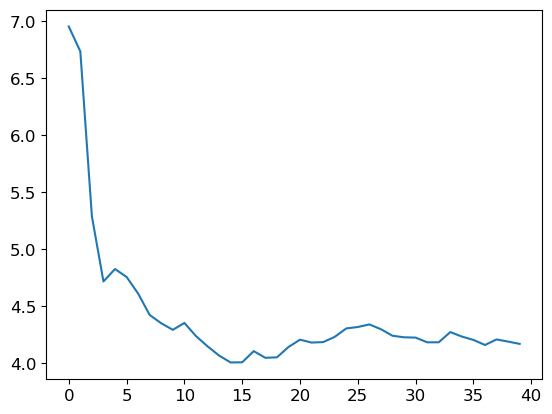

In [64]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

Check OOB error

In [65]:
r_mse(m.oob_prediction_, y)

2.715385

Get STD deviation over all trees, for each *sales* item

In [66]:
preds_std = preds.std(0)

Check STD deviation of first 5 rows of validation set

In [67]:
preds_std[:5]

array([3.3053311 , 4.39889521, 4.26608112, 0.69927518, 2.67323962])

Create a function to return a dataframe with *feature importance*

In [72]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp': m.feature_importances_}).sort_values('imp', ascending=False)

In [73]:
fi = rf_feat_importance(m, xs)

In [74]:
fi[:10]

,cols,imp
1,family,0.517971
3,store_nbr,0.219334
4,onpromotion,0.114358
2,id,0.089109
0,date,0.059228
